In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 04: Seleção de modelo e hiperparametros

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de treino e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [2]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=SEED)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


# Valores de c a serem testados
cs = np.logspace(-3, 3, num=7)

train_mse = []
val_mse = []

for c in cs:
    # Treina o modelo
    model = Ridge(alpha=c)
    model.fit(X_train, y_train)
    
    # Calcula o MSE no conjunto de treino e validação
    train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
    val_mse.append(mean_squared_error(y_val, model.predict(X_val)))

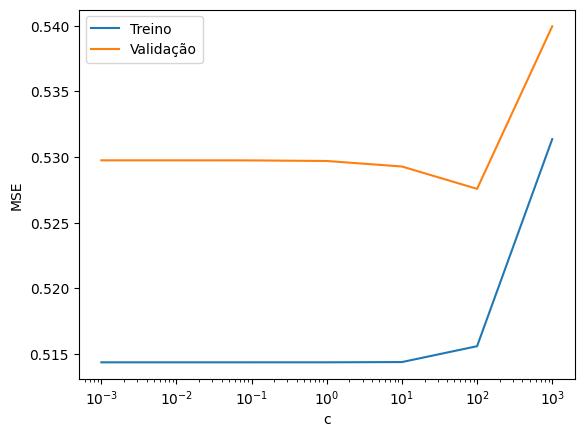

In [5]:
import matplotlib.pyplot as plt

plt.plot(cs, train_mse, label='Treino')
plt.plot(cs, val_mse, label='Validação')
plt.xscale('log')
plt.xlabel('c')
plt.ylabel('MSE')
plt.legend()
plt.show()

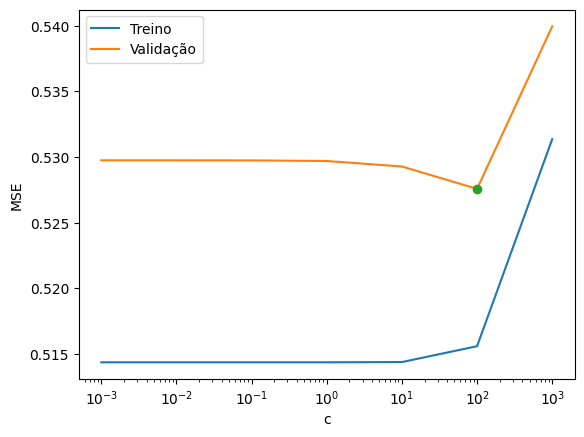

In [6]:
i = np.argmin(val_mse)
x_min_val = cs[i]
y_min_val = val_mse[i]
plt.plot(cs, train_mse, label='Treino')
plt.plot(cs, val_mse, label='Validação')
plt.plot(x_min_val, y_min_val, marker='o')
plt.xscale('log')
plt.xlabel('c')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [7]:
x_min_val

100.0

In [8]:
y_min_val

0.5275765246861027

In [9]:
best_c = x_min_val

model = Ridge(alpha=best_c)
model.fit(X_train_val, y_train_val)

test_mse = mean_squared_error(y_test, model.predict(X_test))
print(f'MSE no conjunto de teste: {test_mse:.4f}')

MSE no conjunto de teste: 0.5497


In [10]:
test_mse = []
for c in cs:
    # Treina o modelo
    model = Ridge(alpha=c)
    model.fit(X_train, y_train)
    
    # Calcula o MSE no conjunto de treino e validação
    test_mse.append(mean_squared_error(y_test, model.predict(X_test)))

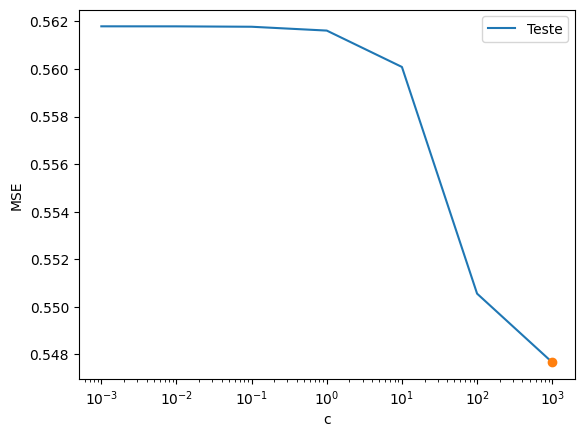

In [11]:
i = np.argmin(test_mse)
x_min_test = cs[i]
y_min_test = test_mse[i]
plt.plot(cs, test_mse, label='Teste')
plt.plot(x_min_test, y_min_test, marker='o')
plt.xscale('log')
plt.xlabel('c')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [12]:
x_min_test

1000.0

In [13]:
y_min_test

0.547669688513095

Dada a fórmula analítica para estimação dos pesos do modelo de regressão:

$$\hat{\beta} = (X^TX+cI)^{-1}X^Ty$$

Podemos usá-la então para estimar os pesos usando o $c$ ideal que encontramos aplicando o MSE no conjunto de validação:

In [14]:
best_c

100.0

In [15]:
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Estima os pesos do modelo
c = best_c
I = np.eye(X_train_val.shape[1])
XtX_cI_inv = np.linalg.inv(X_train_val.T @ X_train_val + c*I)
beta = XtX_cI_inv @ X_train_val.T @ y_train_val

print(beta)

[ 5.04277122e-01  1.59801851e-02 -1.60666277e-01  7.92890994e-01
  9.20281892e-06 -4.34234083e-03 -6.67758831e-02 -1.70941285e-02]


**2.** Implemente 5-fold *nested cross validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido? (Use 5-fold cross validation regular para isso)

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

In [16]:
# Hiperparâmetros para o k-NN
k_values = [1, 2, 3, 4, 5]

# Hiperparâmetros para a regressão linear com regularização L2
c_values = [0, 1, 10, 100]

In [17]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# Definindo a estratégia de validação cruzada para o processo de seleção de modelo
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Definindo as listas para armazenar as métricas de desempenho dos modelos
knn_scores = []
linreg_scores = []

# Loop externo para a validação cruzada
for train_val_index, test_index in outer_cv.split(X, y):
    # Divisão do conjunto de treino e validação
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]
    
    # Definindo a estratégia de validação cruzada interna para a seleção de hiperparâmetros
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Busca pelos melhores hiperparâmetros do k-NN
    knn_best_score = None
    knn_best_params = None
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn_score = cross_val_score(knn, X_train_val, y_train_val, cv=inner_cv, scoring='neg_mean_squared_error')
        knn_score = -np.mean(knn_score)
        if knn_best_score is None or knn_score < knn_best_score:
            knn_best_score = knn_score
            knn_best_params = {'k': k}
    knn_scores.append(knn_best_score)
    
    # Busca pelos melhores hiperparâmetros da regressão linear com regularização L2
    linreg_best_score = None
    linreg_best_params = None
    for c in c_values:
        linreg = Ridge(alpha=c)
        linreg_score = cross_val_score(linreg, X_train_val, y_train_val, cv=inner_cv, scoring='neg_mean_squared_error')
        linreg_score = -np.mean(linreg_score)
        if linreg_best_score is None or linreg_score < linreg_best_score:
            linreg_best_score = linreg_score
            linreg_best_params = {'c': c}
    linreg_scores.append(linreg_best_score)

# Cálculo da média das métricas de desempenho para cada modelo
knn_mean_score = np.mean(knn_scores)
linreg_mean_score = np.mean(linreg_scores)

print('KNN scores:', knn_scores)
print('KNN mean score:', knn_mean_score)
print('Best k:', k)
print(" ")
print('Ridge regression scores:', linreg_scores)
print('Ridge regression mean score:', linreg_mean_score)
print('Best c:', c)

KNN scores: [1.1642754275617304, 1.168352328147758, 1.179164644195872, 1.1628296532740954, 1.150992774006951]
KNN mean score: 1.1651229654372812
Best k: 5
 
Ridge regression scores: [0.5223451793773618, 0.5259037883831157, 0.5304420008551423, 0.5567452655678536, 0.5217951976548812]
Ridge regression mean score: 0.531446286367671
Best c: 100


# Exercício de "papel e caneta"

**1.** Nas nota de aula, derivamos o "dilema viés-variância" calculando o MSE esperado entre a função alvo de aprendizado $f$ e a predição do nosos modelo $h_{\mathcal{D}}$:

$$
\mathbb{E}_{x, \mathcal{D}} 
    \left[ 
        \left( 
        h_{\mathcal{D}}(x) - f\left(x\right) 
        \right)^2
    \right] =
\mathbb{E}_{x}[\underbrace{\textrm{Var}_{\mathcal{D}}[
        h_{\mathcal{D}}(x)]}_{\text{ Variância} }] + \mathbb{E}_{x} [ (\underbrace{\mathbb{E}_{\mathcal{D}}[
        h_{\mathcal{D}}(x) - f\left(x\right)]  }_{\text{Viés}})^2] 
    .
$$

Com isso em mente, adapte nossa derivação para o caso em que as respostas de teste $f(x)$ são corrompidas por um ruído aditivo aleatório $\epsilon$ com média zero e variância finita $\textrm{Var}[\epsilon]=\sigma^2$, i.e., ovbservamos $f^\prime(x) = f(x) + \epsilon$. Mais concretamente, trabalhe a seguinte esperança para derivar uma decomposição similar à da nota de aula:
$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right).
        \right)^2
    \right] 
$$

Compare a diferença entre a decomposição que você obteve e a da nota de aula.

Dica: sua decomposição deve se diferenciar da acima em apenas um termo aditivo, que envolve uma esperança sobre $x$ e $y$.


Para adaptar a derivação do dilema viés-variância para o caso em que as respostas de teste $f(x)$ são corrompidas por um ruído aditivo aleatório $\epsilon$ com média zero, temos, primeiramente:

$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right)
        \right)^2
    \right] = \mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        h^2_{\mathcal{D}}(x) - 2.h_{\mathcal{D}}(x).f^\prime\left(x\right) + {f^\prime}^2\left(x\right)
    \right],
$$
que podemos reescrever como
$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[h^2_{\mathcal{D}}(x)\right] - 2\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).f^\prime\left(x\right)\right] + \mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[{f^\prime}^2\left(x\right)\right] = 
    \mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[h^2_{\mathcal{D}}(x)\right] - 2\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).(f\left(x\right)+\epsilon)\right] + \mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[(f\left(x\right)+\epsilon)^2\right]
$$
devido à linearidade do valor esperado.

Agora, como a variância é dada por $\textrm{Var}(x) = \mathbb{E}[x-\mathbb{E}[x]]^2 = \mathbb{E}[x^2]-(\mathbb{E}[x])^2$, podemos aplicá-la da seguinte maneira:

$$
\textrm{Var}(h_{\mathcal{D}}(x)) = \mathbb{E}[h^2_{\mathcal{D}}(x)]-(\mathbb{E}[h_{\mathcal{D}}(x)])^2 \Rightarrow \mathbb{E}[h^2_{\mathcal{D}}(x)] = \textrm{Var}(h_{\mathcal{D}}(x)) + (\mathbb{E}[h_{\mathcal{D}}(x)])^2 \\
\textrm{Var}(f\left(x\right)+\epsilon) = \mathbb{E}[(f\left(x\right)+\epsilon)^2]-(\mathbb{E}[f\left(x\right)+\epsilon])^2 \Rightarrow \mathbb{E}[(f\left(x\right)+\epsilon)^2] = \textrm{Var}(f\left(x\right)+\epsilon)+(\mathbb{E}[f\left(x\right)+\epsilon])^2 = \mathbb{E}[f^2\left(x\right)+2.f\left(x\right).\epsilon+\epsilon^2]
$$

Desmembrando o valor esperado acima:

$$
\mathbb{E}[(f\left(x\right)+\epsilon)^2] = \mathbb{E}[f^2\left(x\right)+2.f\left(x\right).\epsilon+\epsilon^2] = \mathbb{E}[f^2\left(x\right)]+2\mathbb{E}[f\left(x\right).\epsilon]+\mathbb{E}[\epsilon^2] = \mathbb{E}[f^2\left(x\right)]+2f\left(x\right).\mathbb{E}[\epsilon]+\mathbb{E}[\epsilon^2] = \\ f^2\left(x\right)+2f\left(x\right).\mathbb{E}[\epsilon]+\mathbb{E}[\epsilon^2]
$$

Dado que a média de $\epsilon$ é igual a zero, $\textrm{Var}(\epsilon) = \mathbb{E}[\epsilon^2]-(\mathbb{E}[\epsilon])^2 = \mathbb{E}[\epsilon^2] - 0 = \sigma^2$.

Agora, fazendo as contas para $\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).f^\prime\left(x\right)\right]$:

$$
\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).f^\prime\left(x\right)\right] = \mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).(f\left(x\right)+\epsilon)\right] = \mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).f\left(x\right)+h_{\mathcal{D}}(x).\epsilon)\right] = \mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).f\left(x\right)\right] + \mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).\epsilon\right] \\
= f\left(x\right)\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x)\right] + \mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x)\right].\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[\epsilon\right]
$$

Novamente usando que a média de $\epsilon$ é zero, temos que $\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x).f^\prime\left(x\right)\right] = f\left(x\right)\mathbb{E}_{x, \epsilon, \mathcal{D}}\left[h_{\mathcal{D}}(x)\right]$.

Assim, $$\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right)
        \right)^2
    \right] = \mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        h^2_{\mathcal{D}}(x) - 2.h_{\mathcal{D}}(x).f^\prime\left(x\right) + {f^\prime}^2\left(x\right)
    \right]= \\
    = \mathbb{E}_{x}\left[ \mathbb{E}_{\mathcal{D}} 
    \left[
        h^2_{\mathcal{D}}(x)\right]\right] + \mathbb{E}_{x}
    \left[
        - 2.\mathbb{E}_{\epsilon, \mathcal{D}} \left[h_{\mathcal{D}}(x)\right].f^\prime\left(x\right) + {f^\prime}^2\left(x\right)
    \right] = \\
    = \mathbb{E}_{x}\left[ \mathbb{E}_{\mathcal{D}} 
    \left[
        h^2_{\mathcal{D}}(x)\right] - \mathbb{E}_{\mathcal{D}} 
    \left[
        h_{\mathcal{D}}(x)\right]^2\right] + \mathbb{E}_{x}\left[ \mathbb{E}_{\epsilon, \mathcal{D}} 
    \left[
        h_{\mathcal{D}}(x)\right]^2 - 2.\mathbb{E}_{\epsilon, \mathcal{D}} \left[h_{\mathcal{D}}(x)\right].f^\prime\left(x\right) + {f^\prime}^2\left(x\right)
    \right] = \\
    = \mathbb{E}_{x}\left[ \mathbb{E}_{\mathcal{D}} 
    \left[
        h^2_{\mathcal{D}}(x)\right] - \mathbb{E}_{\mathcal{D}} 
    \left[
        h_{\mathcal{D}}(x)\right]^2\right] + \mathbb{E}_{x}\left[ \mathbb{E}_{\epsilon, \mathcal{D}} 
    \left[
        h_{\mathcal{D}}(x)\right]^2 - 2.\mathbb{E}_{\epsilon, \mathcal{D}} \left[h_{\mathcal{D}}(x)\right].f^\prime\left(x\right) + {f}^2\left(x\right) + \sigma^2
    \right] = \\
    = \mathbb{E}_{x}[\underbrace{\textrm{Var}_{\mathcal{D}}[
        h_{\mathcal{D}}(x)]}_{\text{ Variância} }] + \mathbb{E}_{x} [ (\underbrace{\mathbb{E}_{\mathcal{D}}[
        h_{\mathcal{D}}(x) - f\left(x\right)]  }_{\text{Viés}})^2] + \sigma^2$$